# Predictive Maintenance Test

## Settings

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import xgboost as xgb

### telemetry

In [221]:
telemetry = pd.read_csv('PdM_telemetry.csv')
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [222]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [223]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

### errors

In [224]:
errors = pd.read_csv('PdM_errors.csv')
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [225]:
errors.dtypes

datetime     object
machineID     int64
errorID      object
dtype: object

In [226]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")

### failures

In [227]:
failures = pd.read_csv('PdM_failures.csv')
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [228]:
failures.dtypes

datetime     object
machineID     int64
failure      object
dtype: object

In [229]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")

### machines

In [230]:
machines = pd.read_csv('PdM_machines.csv')
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [231]:
machines.dtypes

machineID     int64
model        object
age           int64
dtype: object

### maintenance

In [232]:
maint = pd.read_csv('PdM_maint.csv')
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [233]:
maint.dtypes

datetime     object
machineID     int64
comp         object
dtype: object

In [234]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")

## EDA

### Failures General Distributions

In [103]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


<Axes: xlabel='failure'>

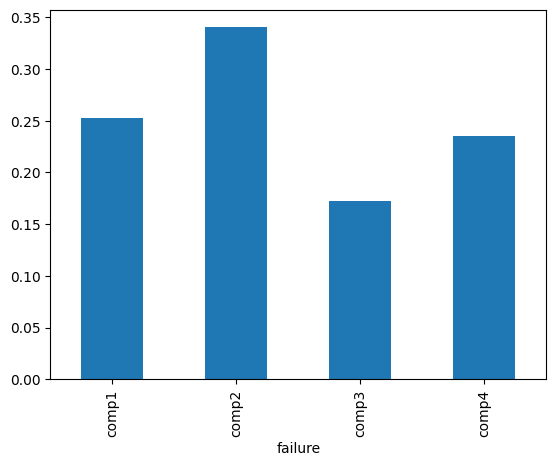

In [104]:
# by component

(failures.failure.value_counts() / failures.shape[0]).sort_index().plot(kind='bar')

<Axes: xlabel='cumulative_failures'>

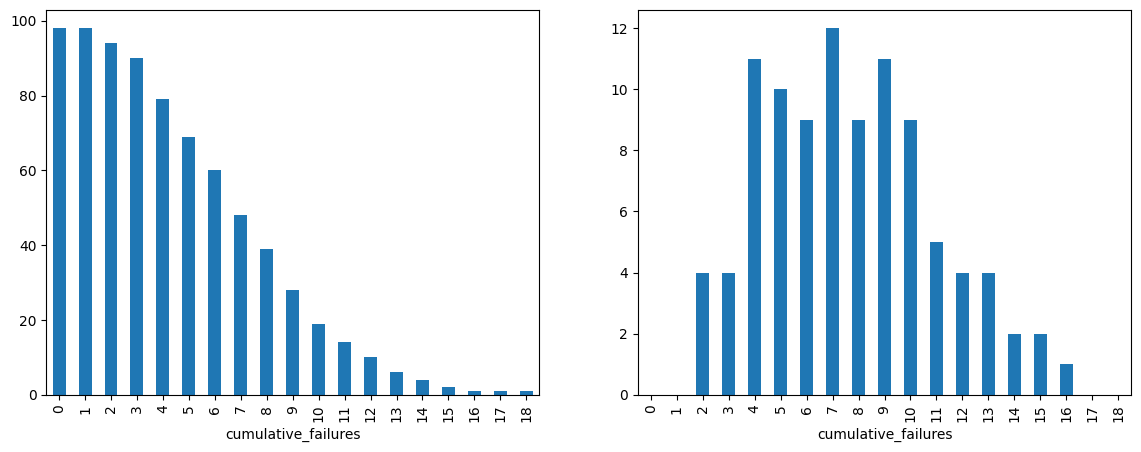

In [105]:
# cumulative failures

failures['cumulative_failures'] = failures.groupby('machineID').datetime.cumcount()

fig, ax = plt.subplots(1,2, figsize=(14, 5))
failures.cumulative_failures.value_counts().plot(kind='bar', ax=ax[0])
failures.cumulative_failures.value_counts().diff().abs().plot(kind='bar', ax=ax[1])

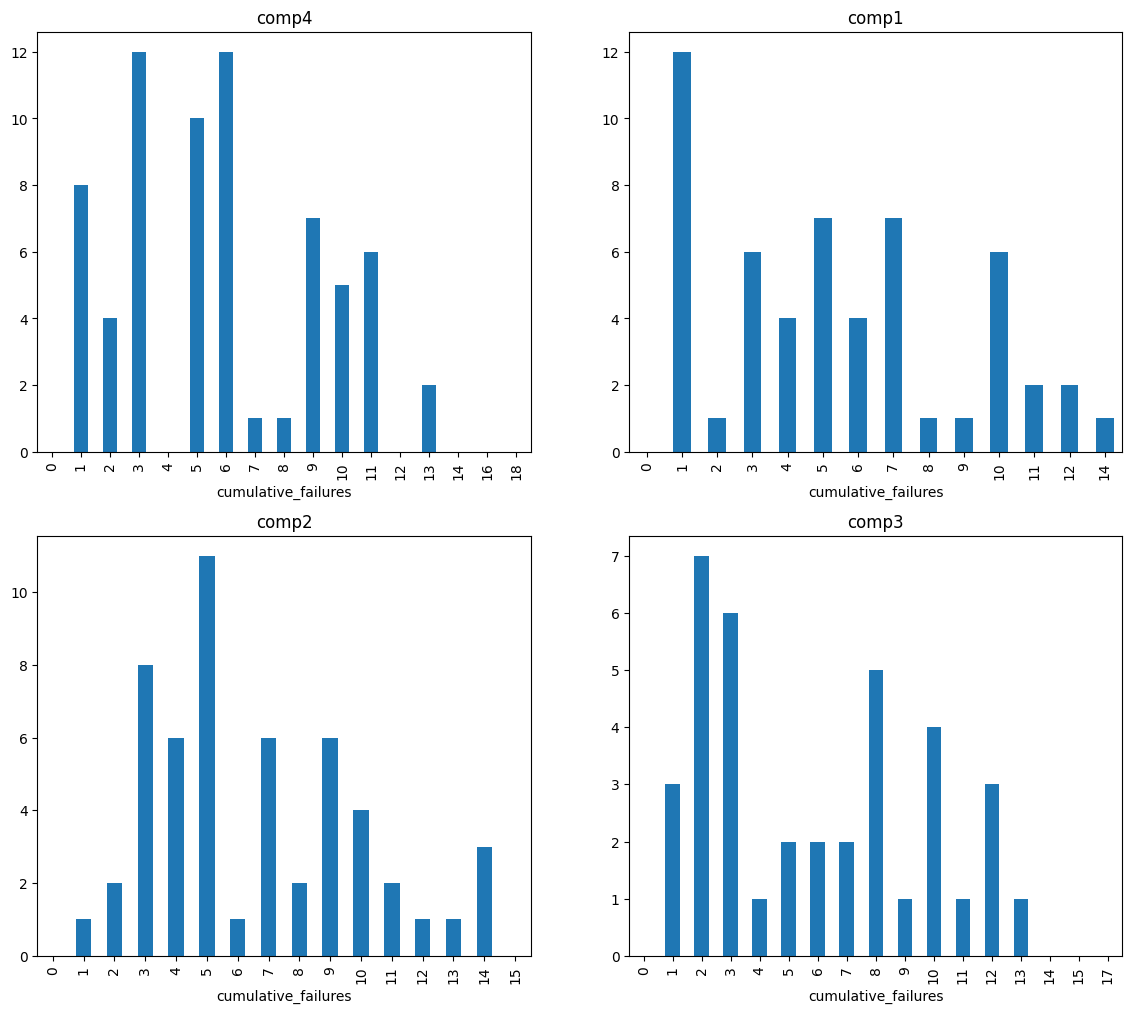

In [106]:
failures['comp_cumulative_failures'] = failures.groupby(['machineID','failure']).cumcount()

fig, ax = plt.subplots(2,2, figsize=(14, 12))
for i, f in enumerate(failures.failure.unique()):
    failures[failures.failure == f].cumulative_failures.value_counts().sort_index().diff().abs().plot(kind='bar', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f)

In [107]:
# days since last failure
failures['days_since_last_failure'] = failures.sort_values('datetime').groupby('machineID').datetime.diff().dt.days
failures['comp_days_since_last_failure'] = failures.sort_values('datetime').groupby(['machineID','failure']).datetime.diff().dt.days
failures

,datetime,machineID,failure,cumulative_failures,comp_cumulative_failures,days_since_last_failure,comp_days_since_last_failure
0,2015-01-05 06:00:00,1,comp4,0,0,NaN,NaN
1,2015-03-06 06:00:00,1,comp1,1,0,60.0,NaN
2,2015-04-20 06:00:00,1,comp2,2,0,45.0,NaN
3,2015-06-19 06:00:00,1,comp4,3,1,60.0,165.0
4,2015-09-02 06:00:00,1,comp4,4,2,75.0,75.0
...,...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,comp3,17,5,30.0,90.0
757,2015-12-14 06:00:00,99,comp4,18,4,15.0,45.0
758,2015-02-12 06:00:00,100,comp1,0,0,NaN,NaN
759,2015-09-10 06:00:00,100,comp1,1,1,210.0,210.0


<Axes: xlabel='days_since_last_failure'>

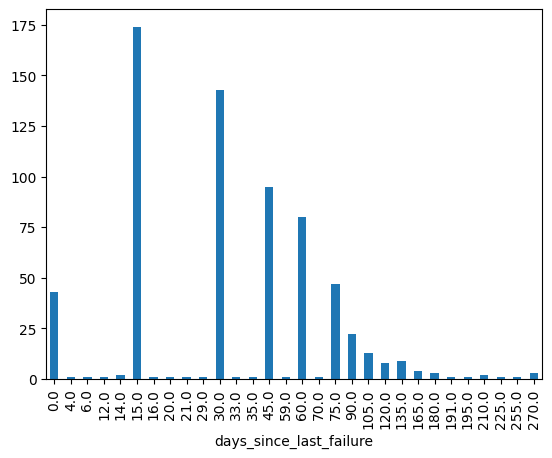

In [108]:
failures.days_since_last_failure.value_counts().sort_index().plot(kind='bar')

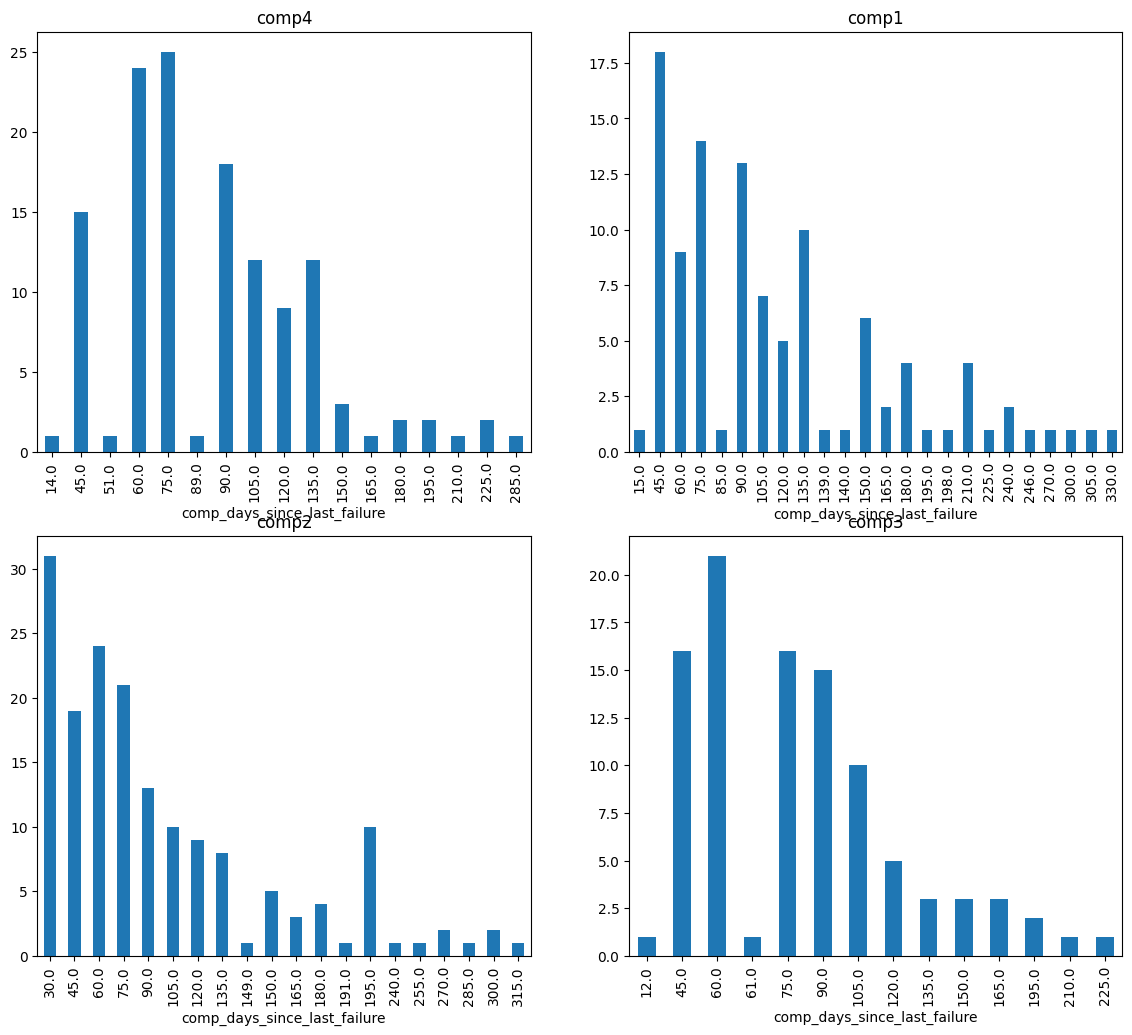

In [109]:
fig, ax = plt.subplots(2,2, figsize=(14, 12))
for i, f in enumerate(failures.failure.unique()):
    failures[failures.failure == f].comp_days_since_last_failure.value_counts().sort_index().plot(kind='bar', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f)


<Axes: xlabel='datetime'>

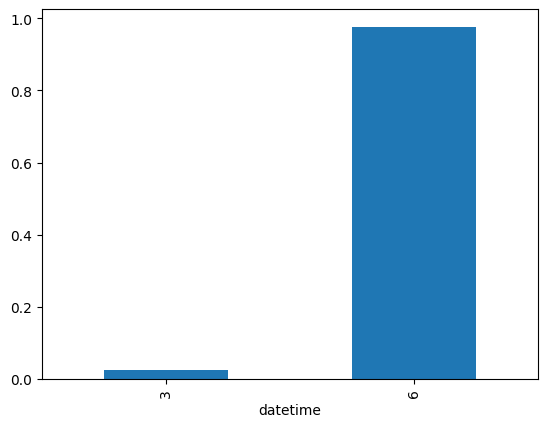

In [110]:
# by hour of the day
(failures['datetime'].dt.hour.value_counts() / failures.shape[0]).sort_index().plot(kind='bar')

<Axes: xlabel='dow'>

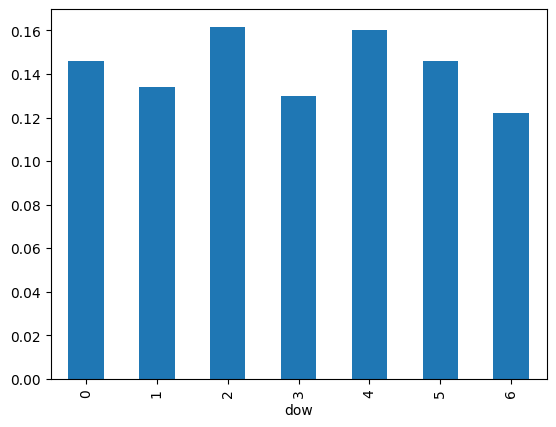

In [111]:
# by day of the week
failures['dow'] = failures['datetime'].dt.dayofweek
(failures.dow.value_counts() / failures.shape[0]).sort_index().plot(kind='bar')

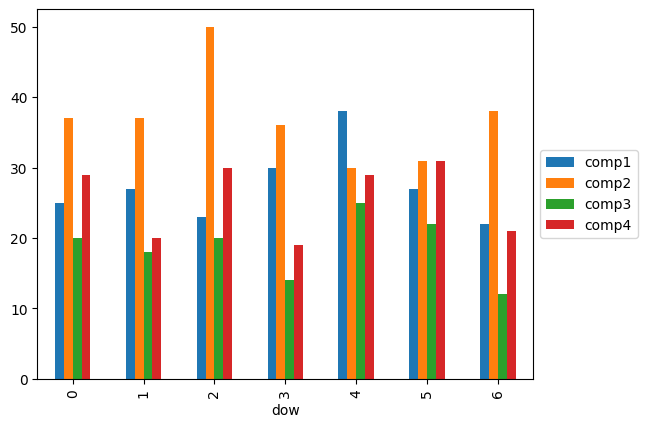

In [112]:
# by dow and component
failures.groupby(['dow', 'failure']).size().unstack().plot(kind='bar', stacked=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

At first glance it looks like some components are more likely to fail than others, which may become more interesting once we analyze the relation with other distributions, such as maintenance distributions. We can also see that if a machine has failed more than 7 times the probability of failing again tends to decrease but this is distribution is different for each component.

There's an interesting pattern where machines and components seem to fail every 15 days or a multiple of 15 days after their last failure. This indicates that a besides adding the number of days since last failure, another good feature would be a dummy indicating if the days are a multiple of 15.

I also thought it would be interesting to see if there's a time pattern: obviously the hour of the day doesn't tell us much, but the day of the week seems to have some relationship with the probability of failure. It seems that failures are more common on wednesdays and fridays, although the distribution varies for each component. For example, comp2 seems to fail less on friday and saturday and more on wednesday and sunday. The idea behind using the day of the week as a feature is that the machines or some components may be more demanded during certain days, leading to a higher probability of failure. Since I have little context on what the machines do, originally I thought maybe they would be less likely to fail on weekends meaning that I could add a dummy indicating if it's a weekday or a weekend. Seeing that each one follows an unique distribution I will probably add each day as a feature.

I didn't include the month because there's only one year of data so it isn't enough to see if there's a monthly seasonality too.  

### Machine Data Distributions

In [113]:
df = failures.merge(machines, on='machineID', how='left')
df.head()

,datetime,machineID,failure,cumulative_failures,comp_cumulative_failures,days_since_last_failure,comp_days_since_last_failure,dow,model,age
0,2015-01-05 06:00:00,1,comp4,0,0,NaN,NaN,0,model3,18
1,2015-03-06 06:00:00,1,comp1,1,0,60.0,NaN,4,model3,18
2,2015-04-20 06:00:00,1,comp2,2,0,45.0,NaN,0,model3,18
3,2015-06-19 06:00:00,1,comp4,3,1,60.0,165.0,4,model3,18
4,2015-09-02 06:00:00,1,comp4,4,2,75.0,75.0,2,model3,18


In [114]:
model_dist = (machines.model.value_counts() / machines.shape[0]).reset_index()
model_dist['subset'] = 'all'
age_dist = (machines.age.value_counts() / machines.shape[0]).reset_index()
age_dist['subset'] = 'all'

def machine_distribtutions_comp(data):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    i = 0
    for col, dist in zip(['model', 'age'], [model_dist, age_dist]):
        failure_dist = (data[col].value_counts() / data.shape[0]).reset_index()
        failure_dist['subset'] = 'failure'
        sns.barplot(x=col, y='count', data=pd.concat([dist, failure_dist]), hue='subset', ax=ax[i])
        i += 1
    
    return ax

array([<Axes: xlabel='model', ylabel='count'>,
       <Axes: xlabel='age', ylabel='count'>], dtype=object)

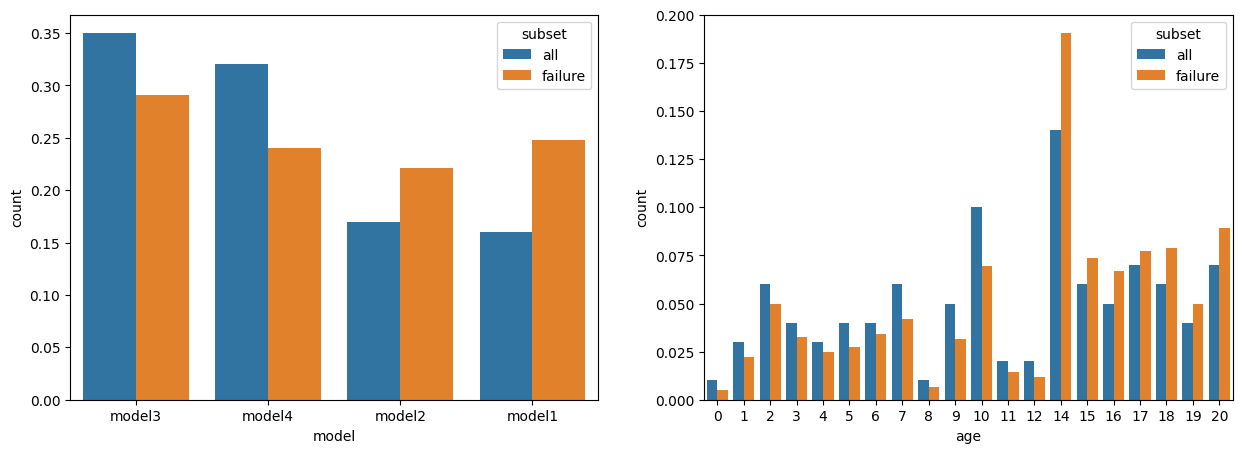

In [115]:
# all failures
machine_distribtutions_comp(df)

array([<Axes: xlabel='model', ylabel='count'>,
       <Axes: xlabel='age', ylabel='count'>], dtype=object)

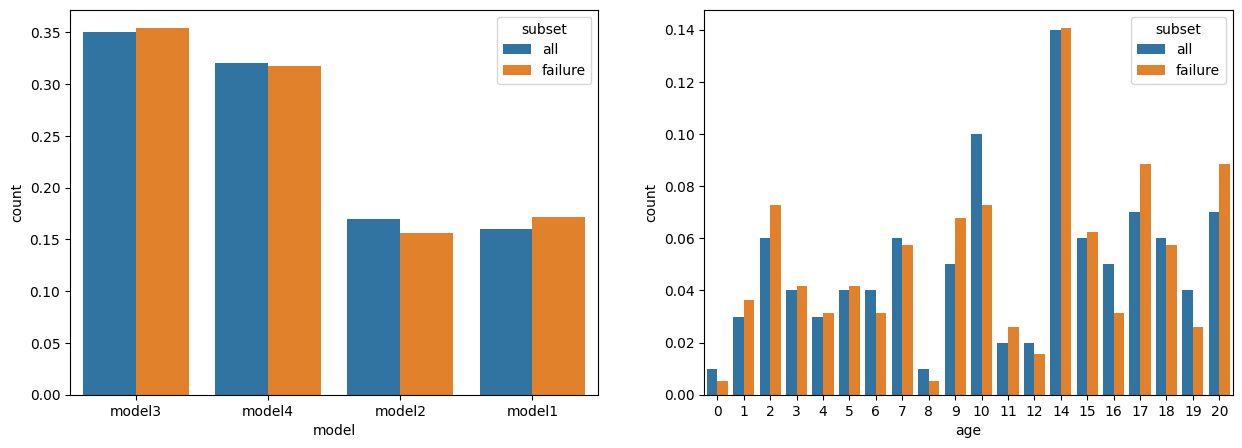

In [116]:
# failure comp1
machine_distribtutions_comp(df[df.failure == 'comp1'])

array([<Axes: xlabel='model', ylabel='count'>,
       <Axes: xlabel='age', ylabel='count'>], dtype=object)

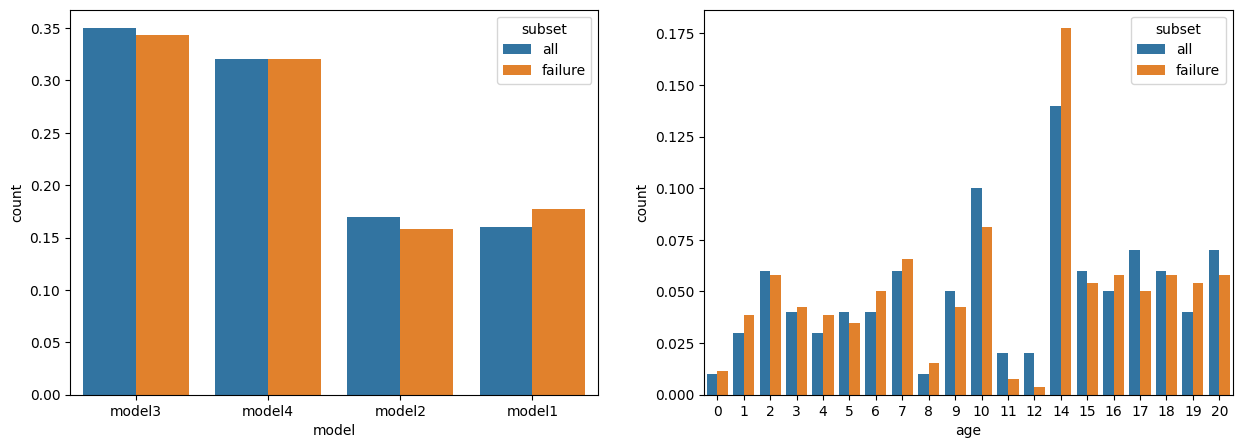

In [117]:
# failure comp2
machine_distribtutions_comp(df[df.failure == 'comp2'])

array([<Axes: xlabel='model', ylabel='count'>,
       <Axes: xlabel='age', ylabel='count'>], dtype=object)

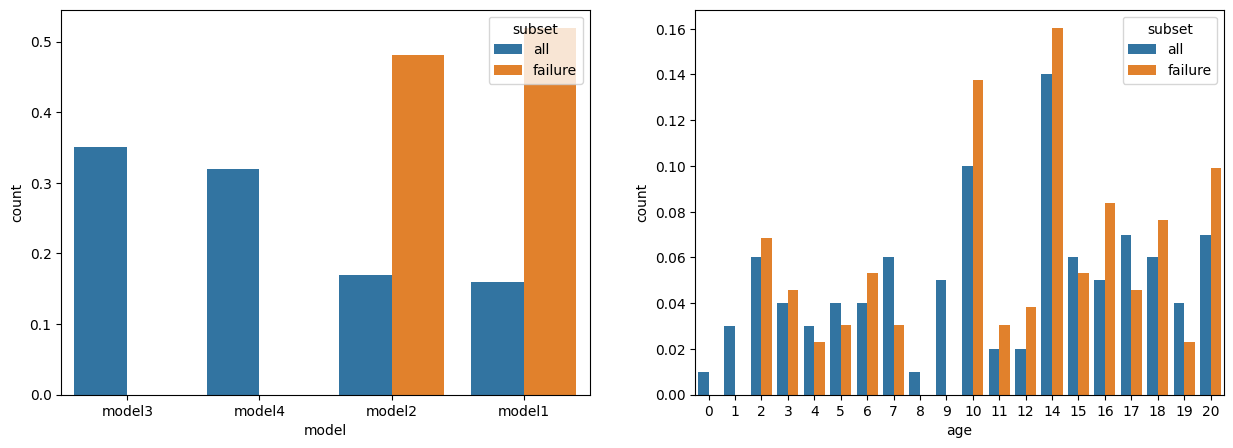

In [118]:
# failure comp3
machine_distribtutions_comp(df[df.failure == 'comp3'])

array([<Axes: xlabel='model', ylabel='count'>,
       <Axes: xlabel='age', ylabel='count'>], dtype=object)

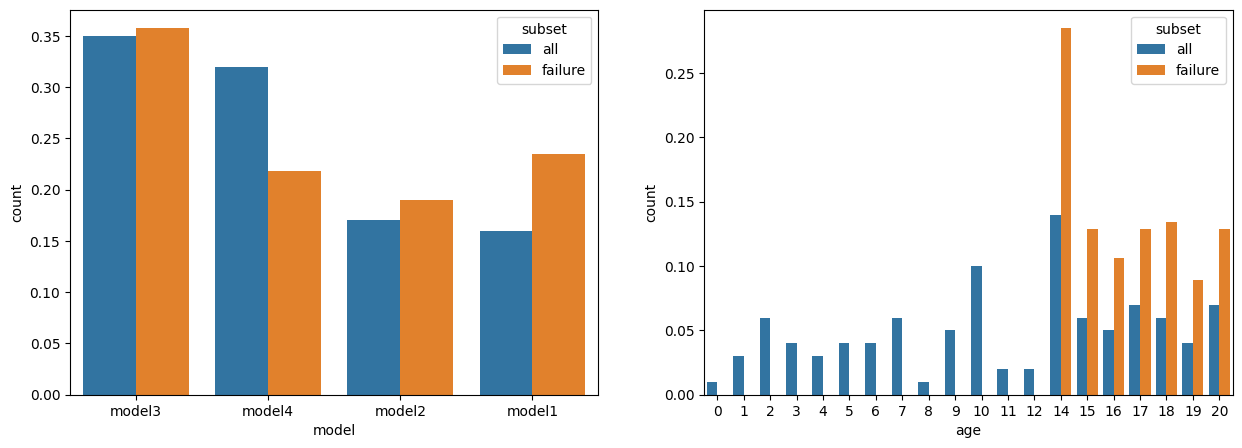

In [119]:
# failure comp4
machine_distribtutions_comp(df[df.failure == 'comp4'])

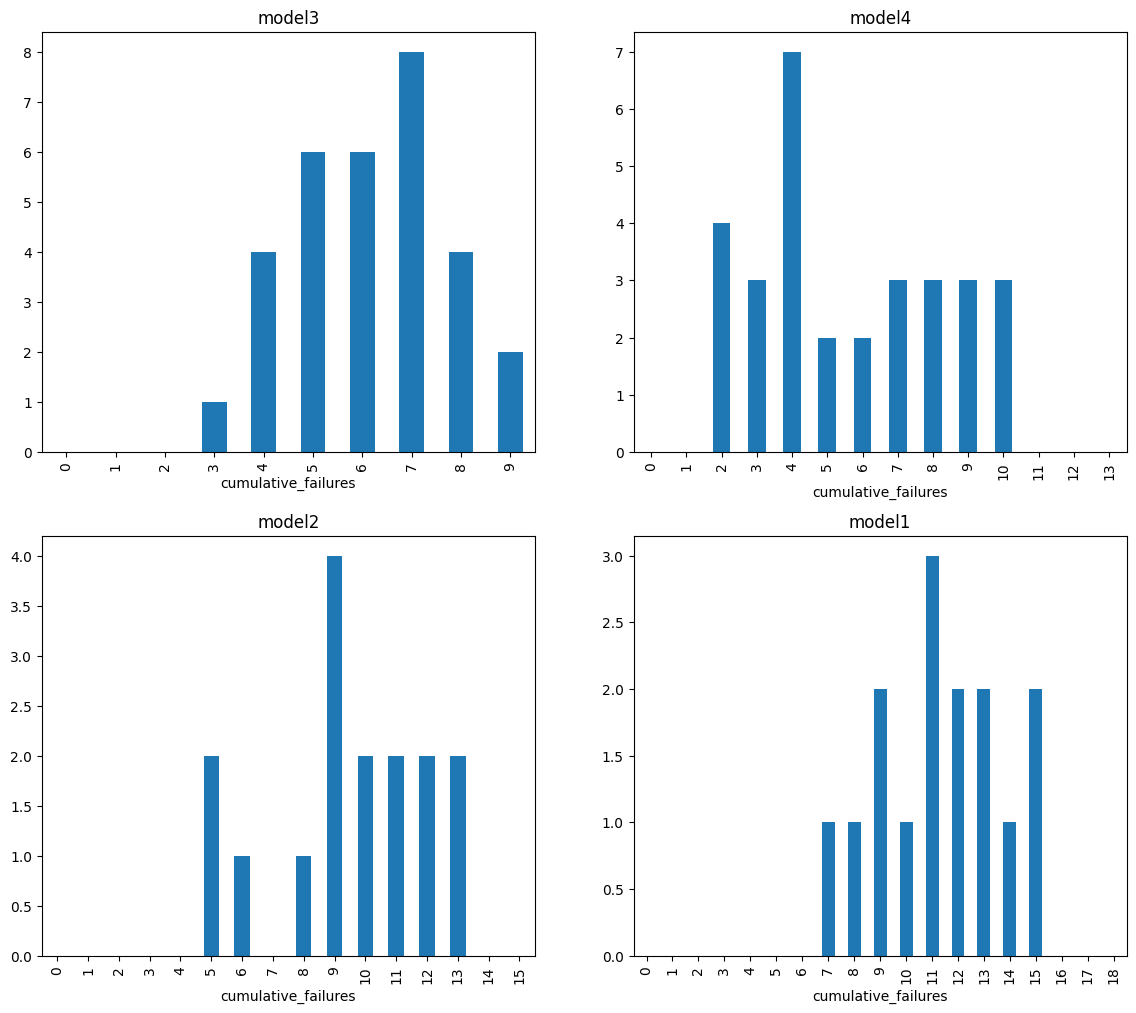

In [120]:
fig, ax = plt.subplots(2,2, figsize=(14, 12))
for i, model in enumerate(df.model.unique()):
    df[df.model == model].cumulative_failures.value_counts().diff().abs().plot(kind='bar', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(model)


On a general level we see that model 1 and 2 tend to fail more than model 3 and 4. We can also see that machines older than 13 years are more likely to have experience failure at some point. 

When we look individually at each component some interesting patterns emerge: comp3 seems to only fail on machines model 1 and 2 while while comp4 seems to only fail after reaching 14 years of usage.

Finally, the last figure also shows that there's an interaction between cumulative failures and models, indicating that it would help to add this interaction as a feature or use a model that can inherently capture this (unlike logistic regressions). The latter seems like a better option since there's probably more interactions among the variables.

### Maintenance Data Distributions

In [121]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


<Axes: xlabel='failure'>

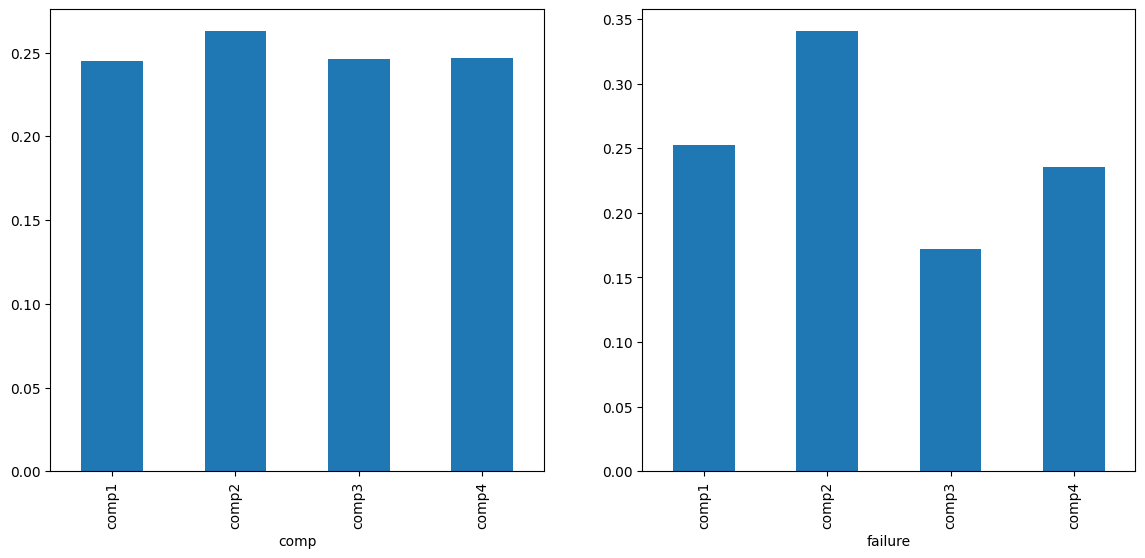

In [122]:
# difference in maintenance vs failures distribution
fig, ax = plt.subplots(1,2, figsize=(14, 6))
(maint.comp.value_counts() / maint.shape[0]).sort_index().plot(kind='bar', ax=ax[0])
(failures.failure.value_counts() / failures.shape[0]).sort_index().plot(kind='bar', ax=ax[1])

<Axes: xlabel='failure'>

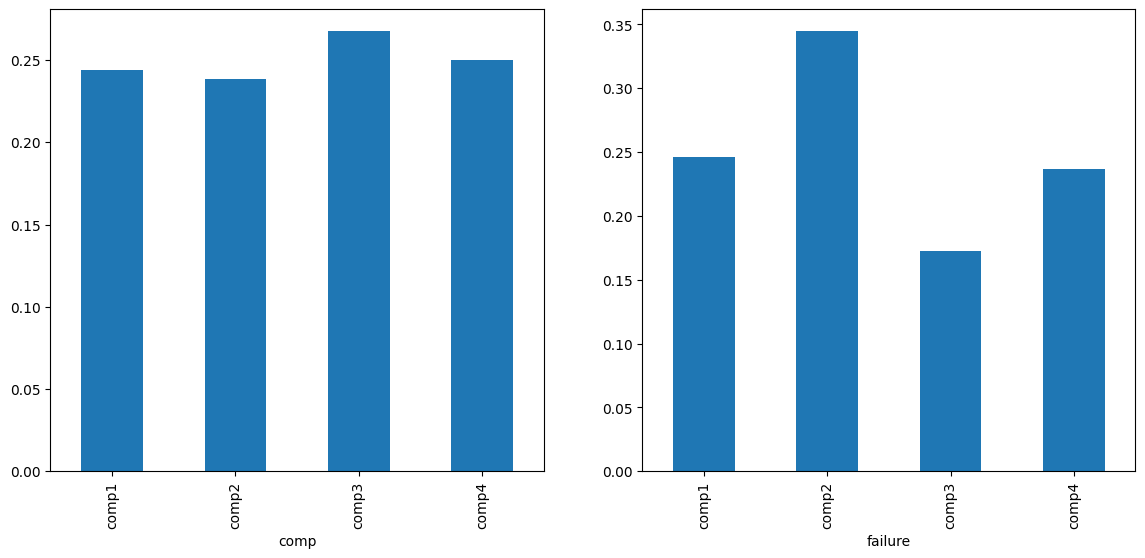

In [123]:
# difference in proactive maintenance vs failures distribution

fm_df = maint.merge(failures, left_on=['datetime', 'machineID', 'comp'], right_on=['datetime', 'machineID', 'failure'], how='left')

fig, ax = plt.subplots(1,2, figsize=(14, 6))
(fm_df[fm_df.failure.isna()].comp.value_counts() / fm_df[fm_df.failure.isna()].shape[0]).sort_index().plot(kind='bar', ax=ax[0])
(fm_df[fm_df.failure.notnull()].failure.value_counts() / fm_df[fm_df.failure.notnull()].shape[0]).sort_index().plot(kind='bar', ax=ax[1])

<Axes: xlabel='cumulative_maint'>

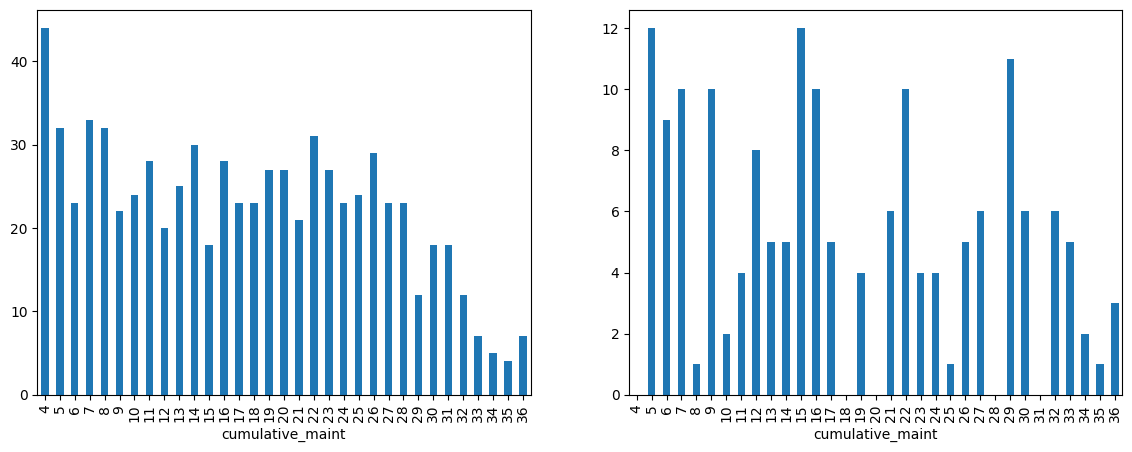

In [124]:
# cumulative maintenance
fm_df['cumulative_maint'] = fm_df.groupby('machineID').cumcount()
fm_df['comp_cumulative_maint'] = fm_df.groupby(['machineID', 'comp']).cumcount()

fig, ax = plt.subplots(1,2, figsize=(14, 5))
fm_df[fm_df.failure.notnull()].cumulative_maint.value_counts().sort_index().plot(kind='bar', ax=ax[0])
fm_df[fm_df.failure.notnull()].cumulative_maint.value_counts().sort_index().diff().abs().plot(kind='bar', ax=ax[1])

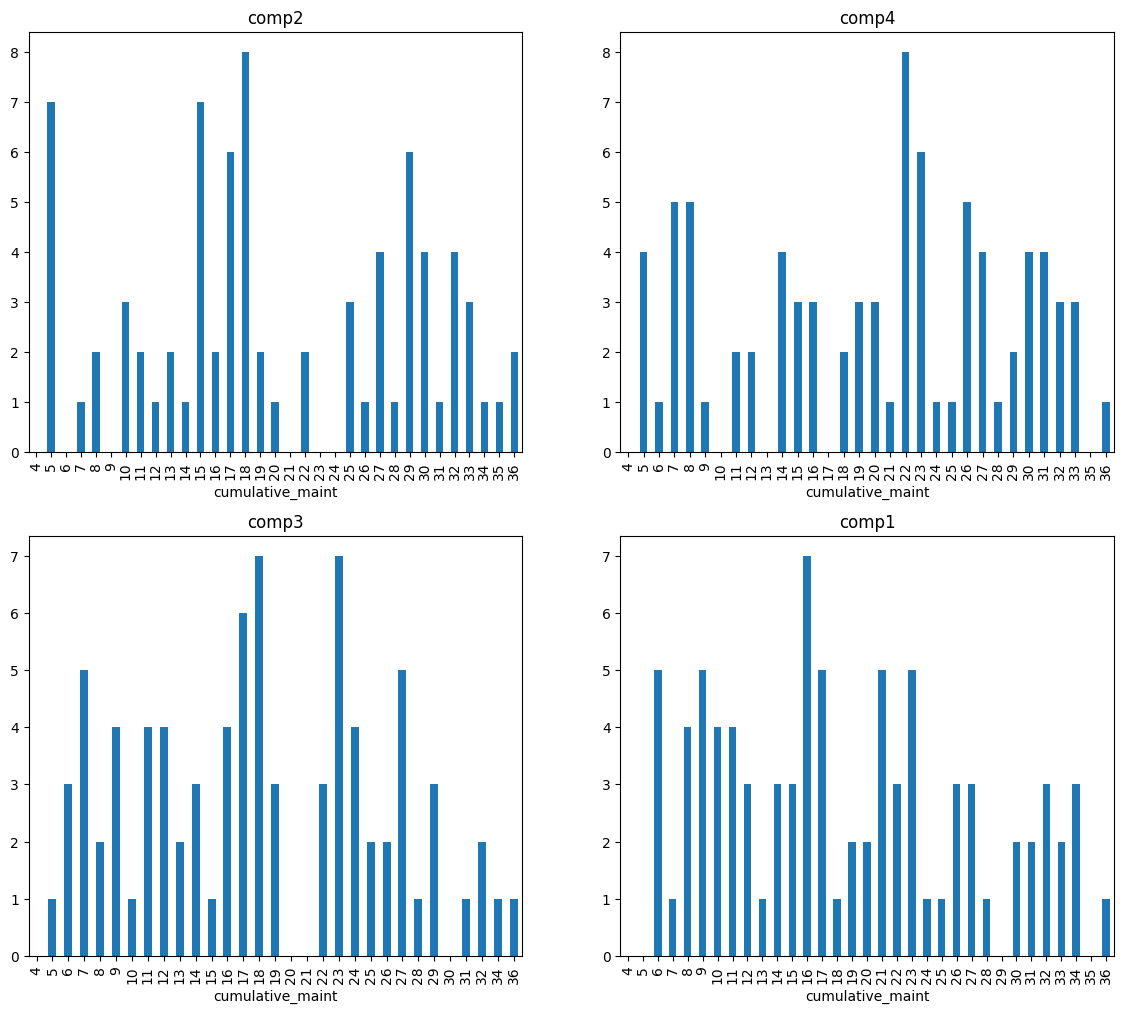

In [125]:
fig, ax = plt.subplots(2,2, figsize=(14, 12))
for i, f in enumerate(fm_df.comp.unique()):
    fm_df[fm_df.failure == f].cumulative_maint.value_counts().sort_index().diff().abs().plot(kind='bar', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f)

In [127]:
# days since last maintenance
fm_df['days_since_last_maint'] = fm_df.sort_values('datetime').groupby('machineID').datetime.diff().dt.days
fm_df['comp_days_since_last_maint'] = fm_df.sort_values('datetime').groupby(['machineID', 'comp']).datetime.diff().dt.days
fm_df.head()

,datetime,machineID,comp,failure,cumulative_failures,comp_cumulative_failures,days_since_last_failure,comp_days_since_last_failure,dow,cumulative_maint,comp_cumulative_maint,days_since_last_maint,comp_days_since_last_maint
0,2014-06-01 06:00:00,1,comp2,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
1,2014-07-16 06:00:00,1,comp4,NaN,NaN,NaN,NaN,NaN,NaN,1,0,45.0,NaN
2,2014-07-31 06:00:00,1,comp3,NaN,NaN,NaN,NaN,NaN,NaN,2,0,15.0,NaN
3,2014-12-13 06:00:00,1,comp1,NaN,NaN,NaN,NaN,NaN,NaN,3,0,135.0,NaN
4,2015-01-05 06:00:00,1,comp4,comp4,0.0,0.0,NaN,NaN,0.0,4,1,0.0,173.0


<Axes: xlabel='days_since_last_maint'>

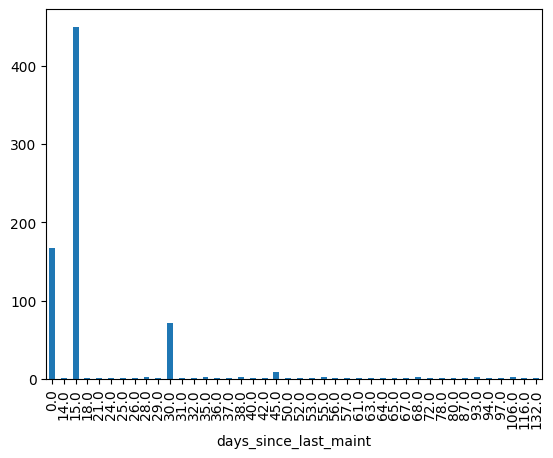

In [128]:
fm_df[fm_df.failure.notnull()].days_since_last_maint.value_counts().sort_index().plot(kind='bar')

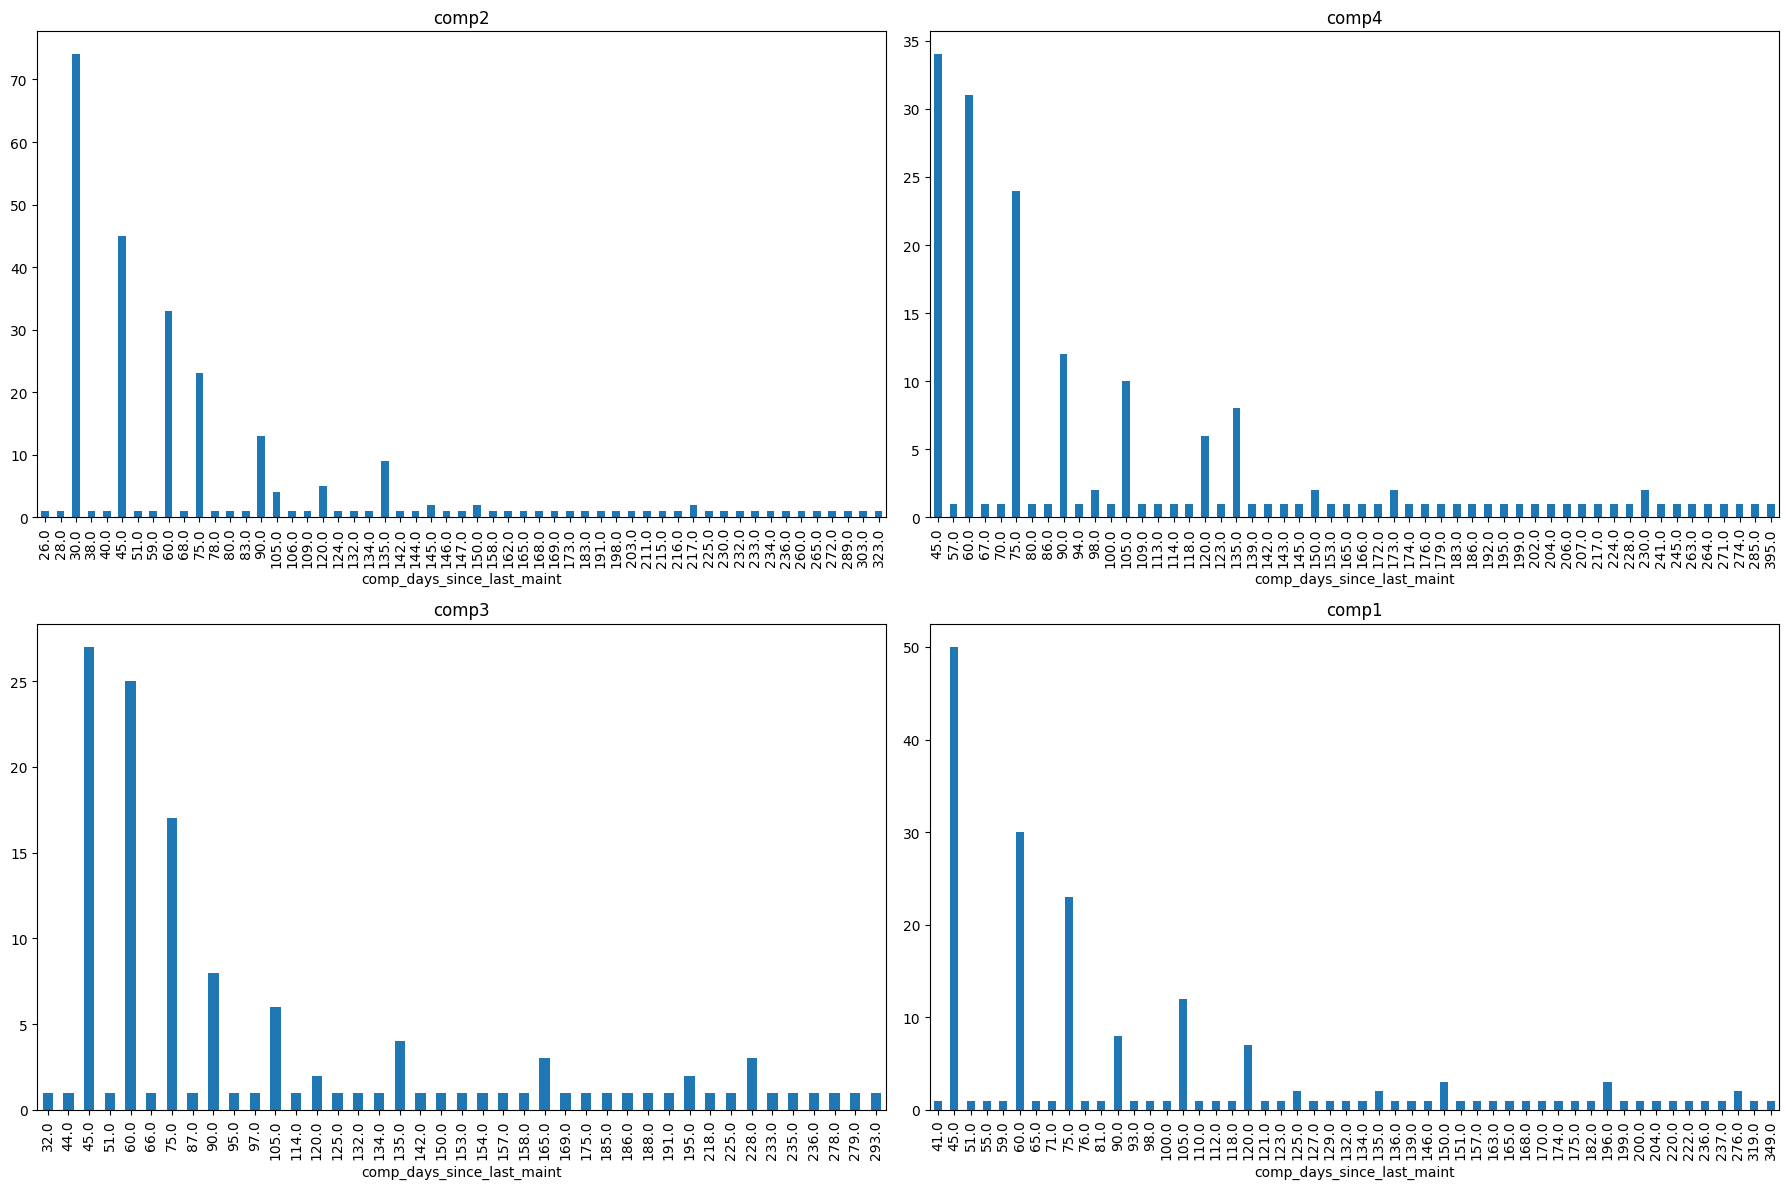

In [129]:
fig, ax = plt.subplots(2,2, figsize=(18, 12))
for i, f in enumerate(fm_df.comp.unique()):
    fm_df[(fm_df.failure == f)].comp_days_since_last_maint.value_counts().sort_index().plot(kind='bar', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f)
plt.tight_layout()

We can see that components are given proactive maintenance in an evenly distributed way but, as we had seen, some components are more likely to fail than others meaning this two distributions aren't well alligned. This is also reflected when looking at the cumulative maintenance distributions. There are no clear patterns in the number of previous maintenance with the number of machines or components that experience failure. 

The days since the last maintenance also shows this weird 15 days pattern so again it could be usefull to add a dummy indicating if the number of days are multiple of 15.


### Errors Distributions

In [43]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


<Axes: xlabel='errorID'>

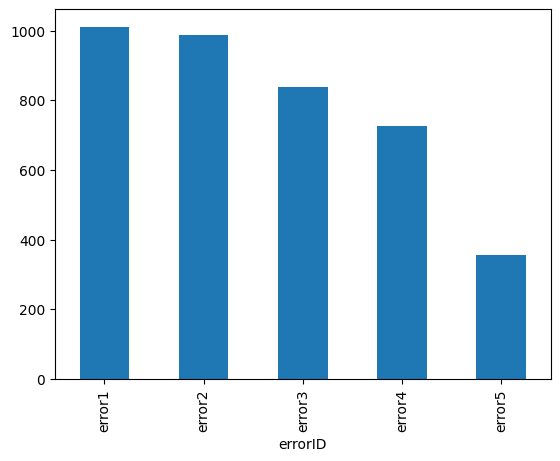

In [44]:
errors.errorID.value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='error_count', ylabel='failure_count'>

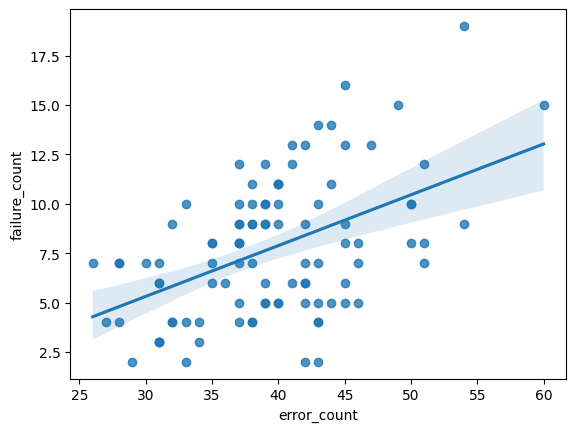

In [45]:
gpd_errors = errors.groupby('machineID').errorID.count()
gpd_failures = failures.groupby('machineID').failure.count()
gpd_data = pd.concat([gpd_errors, gpd_failures], axis=1)
gpd_data.columns = ['error_count', 'failure_count']
sns.regplot(x='error_count', y='failure_count', data=gpd_data)

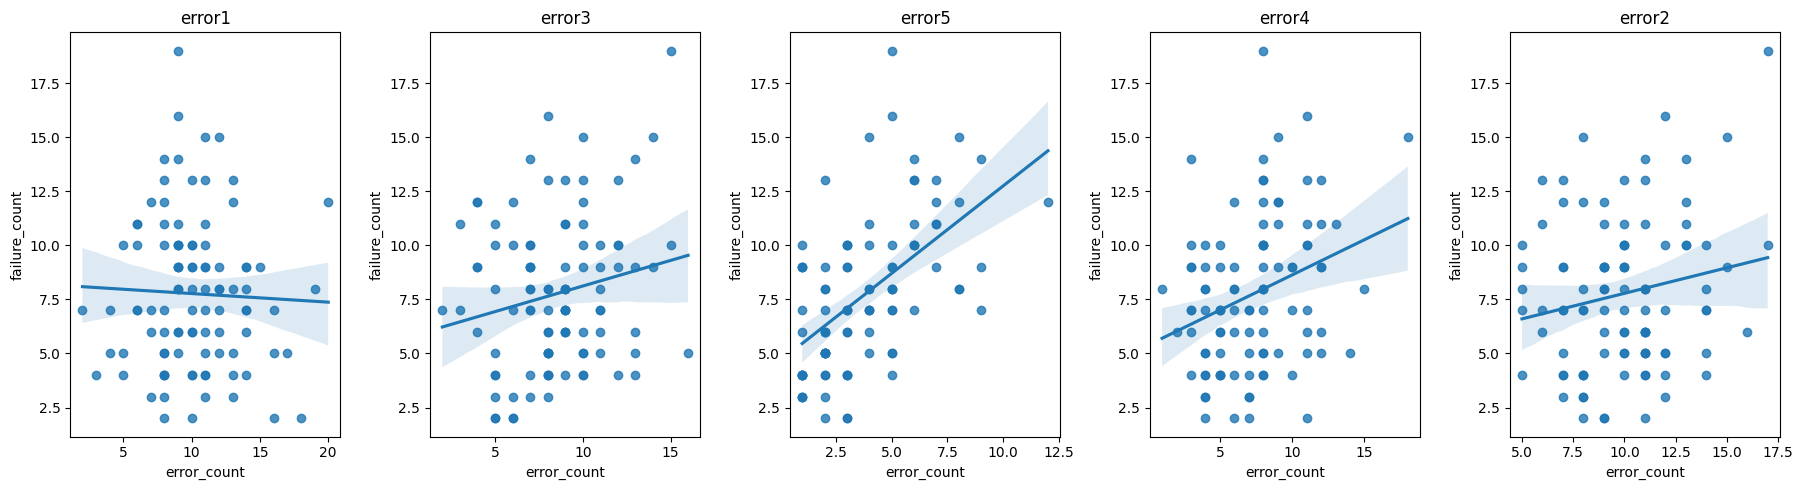

In [46]:
# scatterplots by errorID
fig, ax = plt.subplots(1,5, figsize=(18, 5))
for i, e in enumerate(errors.errorID.unique()):
    gpd_errors = errors[errors.errorID == e].groupby('machineID').errorID.count()
    gpd_failures = failures.groupby('machineID').failure.count()
    gpd_data = pd.concat([gpd_errors, gpd_failures], axis=1)
    gpd_data.columns = ['error_count', 'failure_count']
    sns.regplot(x='error_count', y='failure_count', data=gpd_data, ax=ax[i])
    ax[i].set_title(e)
plt.tight_layout()

### Telemetry Distributions

In [119]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [120]:
cols = ['volt', 'rotate', 'pressure', 'vibration']
telemetry[cols] = telemetry.groupby('machineID')[cols].shift(24)

ld_cols = [c + '_ld_mean' for c in cols]
l3d_cols = [c + '_l3d_mean' for c in cols]
lw_cols = [c + '_lw_mean' for c in cols]
l2w_cols = [c + '_l2w_mean' for c in cols]
telemetry[ld_cols] = telemetry.groupby('machineID').rolling(24)[cols].mean().values
telemetry[l3d_cols] = telemetry.groupby('machineID').rolling(24*3)[cols].mean().values
telemetry[lw_cols] = telemetry.groupby('machineID').rolling(24*7)[cols].mean().values
telemetry[l2w_cols] = telemetry.groupby('machineID').rolling(24*7*2)[cols].mean().values

In [121]:
failures.datetime.dt.hour.value_counts()

datetime
6    743
3     18
Name: count, dtype: int64

In [122]:
maint.datetime.dt.hour.value_counts()

datetime
6    3286
Name: count, dtype: int64

In [123]:
# since almost all failures are registered at 6 am I thought we could simplify everything by shifting datetime 6 hours back and handle everything daily
# after all, since the objective is to predict failure 24 hours before, it make sense to have it this way
# This is just because, for some reason, all maintenance and failures are registered at 6 am, otherwise I would have used hourly data

telemetry = telemetry[telemetry.datetime.dt.hour == 6].copy(deep=True)
telemetry['datetime'] = telemetry.datetime.dt.date
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,pressure_l3d_mean,vibration_l3d_mean,volt_lw_mean,rotate_lw_mean,pressure_lw_mean,vibration_lw_mean,volt_l2w_mean,rotate_l2w_mean,pressure_l2w_mean,vibration_l2w_mean
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,99.061612,43.779924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
failures['datetime'] = failures.datetime.dt.date
failures.head()

,datetime,machineID,failure,cumulative_failures,comp_cumulative_failures,days_since_last_failure,comp_days_since_last_failure,dow
0,2015-01-05,1,comp4,0,0,NaN,NaN,0
1,2015-03-06,1,comp1,1,0,60.0,NaN,4
2,2015-04-20,1,comp2,2,0,45.0,NaN,0
3,2015-06-19,1,comp4,3,1,60.0,165.0,4
4,2015-09-02,1,comp4,4,2,75.0,75.0,2


In [126]:
tf_df = telemetry.merge(failures, how='left') # telemetry and failure df

In [142]:
def plot_telemtery_dists(columns):
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    for i, col in enumerate(columns):
        sns.histplot(tf_df[col][tf_df.failure.isnull()], ax=ax[i//2, i%2], stat='probability', bins = 30)
        sns.histplot(tf_df[col][tf_df.failure.notnull()], ax=ax[i//2, i%2], color='red', alpha=0.6, stat='probability', bins = 30)
        ax[i//2, i%2].set_title(col)
    plt.tight_layout() 

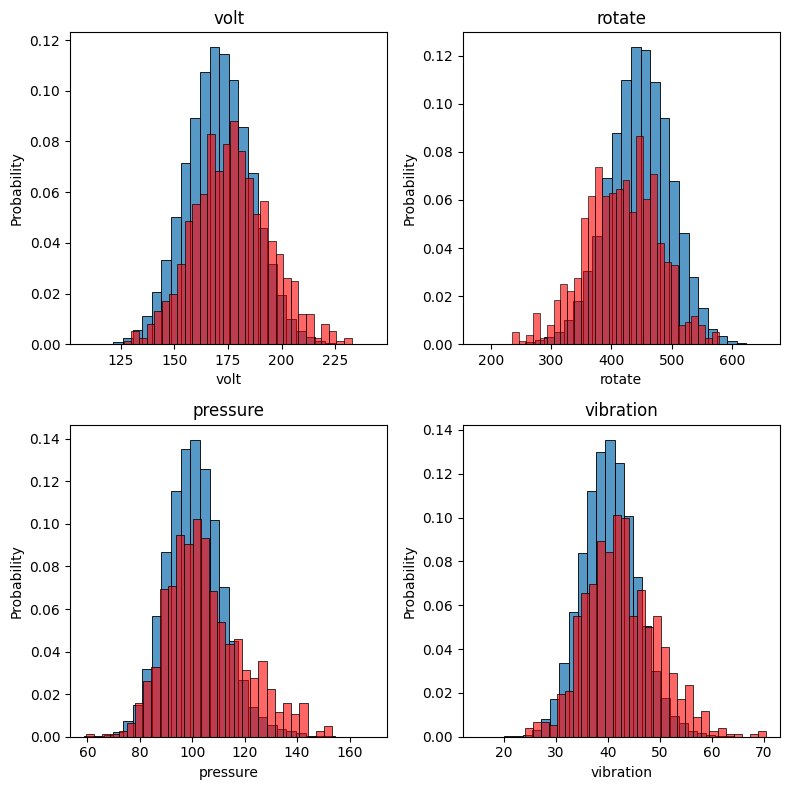

In [143]:
# distribution of values 24 hrs prev

plot_telemtery_dists(cols)

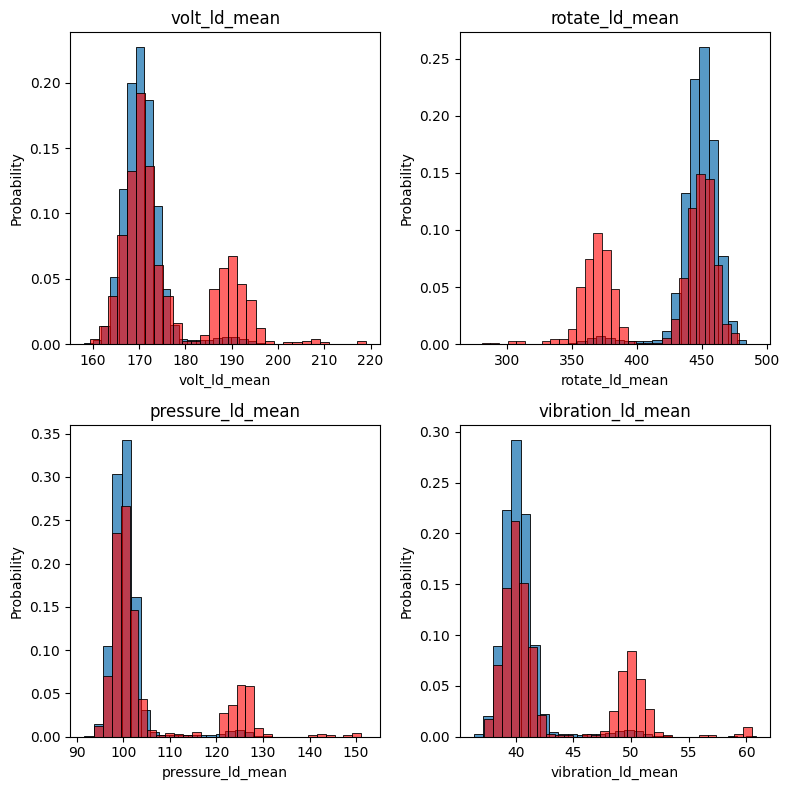

In [144]:
# distribution of last day means

plot_telemtery_dists(ld_cols)

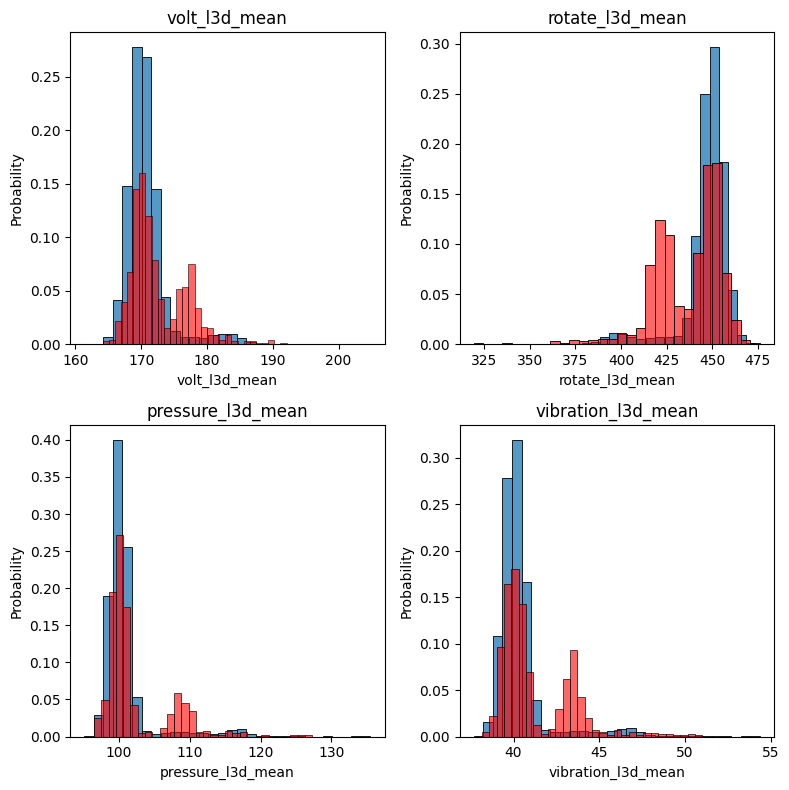

In [145]:
# distribution of last 3 day means

plot_telemtery_dists(l3d_cols)

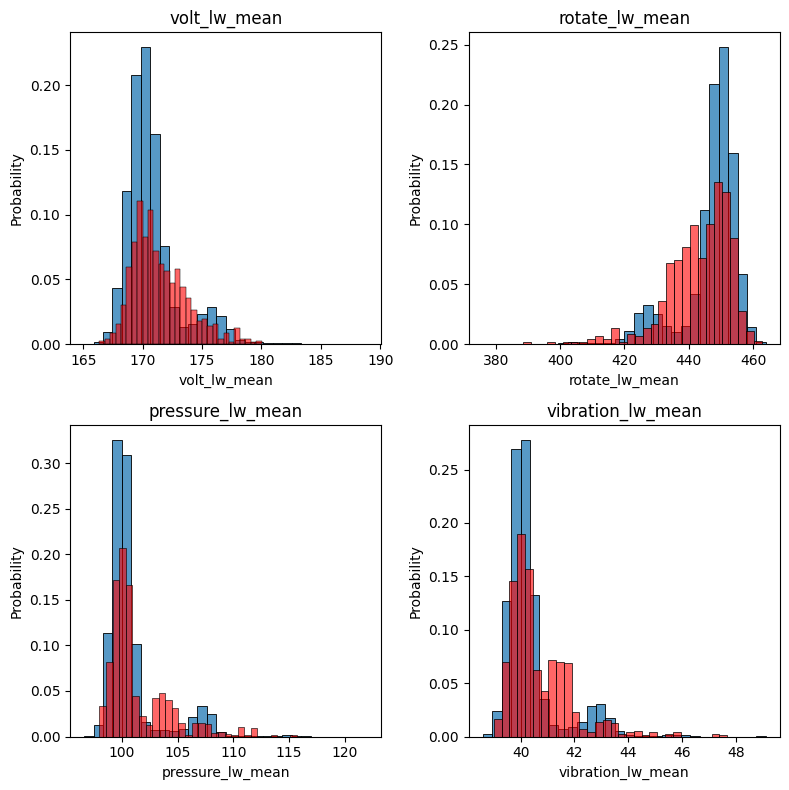

In [146]:
# distribution of last week means

plot_telemtery_dists(lw_cols)

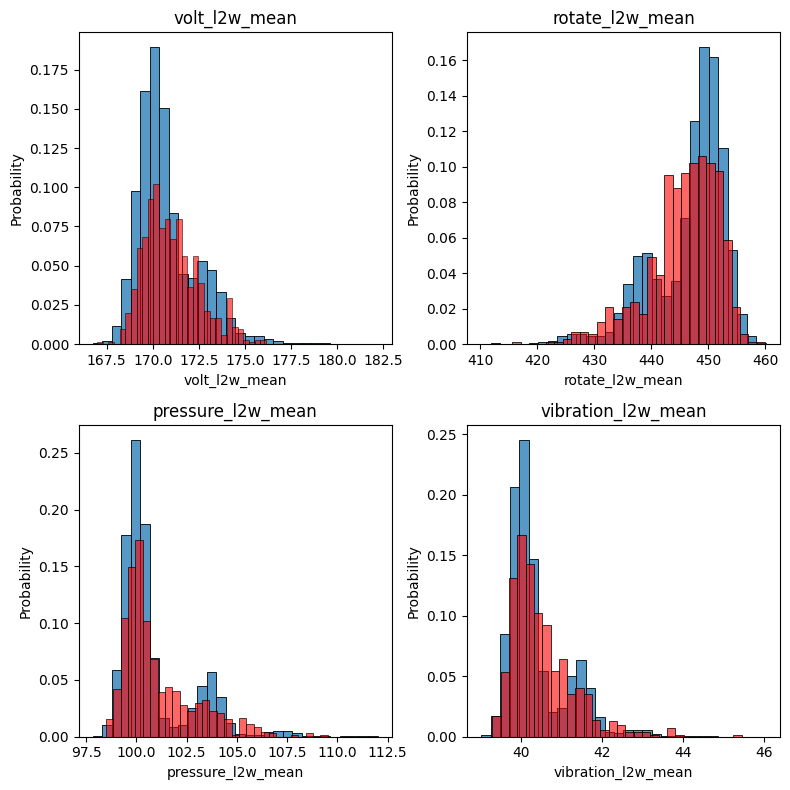

In [147]:
# distribution of last 2 weeks mean

plot_telemtery_dists(l2w_cols)

After looking at telemetry data I believe structuring the data in a daily way would be better than handling hourly data. Especially due to maintenance and faliure data having all observations at 6 am. Using daily data we can see that the average last day values, the average last 3 day values and the average last week values seem to be the best features due to the difference in the distributions. 

## Dataset Construction

In this section I assume that I haven't run any of the EDA cells, so I start out with the original DataFrames.

In [235]:
# changes to telemetry data
cols = ['volt', 'rotate', 'pressure', 'vibration']
telemetry[cols] = telemetry.groupby('machineID')[cols].shift(24) # data 24 hours before

# last day mean
ld_cols = [c + '_ld_mean' for c in cols]
telemetry[ld_cols] = telemetry.groupby('machineID').rolling(24)[cols].mean().values
# last 3 days mean
l3d_cols = [c + '_l3d_mean' for c in cols]
telemetry[l3d_cols] = telemetry.groupby('machineID').rolling(24*3)[cols].mean().values
# last week mean
lw_cols = [c + '_lw_mean' for c in cols]
telemetry[lw_cols] = telemetry.groupby('machineID').rolling(24*7)[cols].mean().values
# last 2 weeks mean
l2w_cols = [c + '_l2w_mean' for c in cols] 
telemetry[l2w_cols] = telemetry.groupby('machineID').rolling(24*7*2)[cols].mean().values

# since almost all failures are registered at 6 am I thought we could simplify everything by handling everything daily
telemetry = telemetry[telemetry.datetime.dt.hour == 6].copy(deep=True)
telemetry['datetime'] = telemetry.datetime.dt.date

In [236]:
# changes to failures
failures['datetime'] = failures.datetime.dt.date

In [237]:
# merge in one df

df = telemetry.merge(pd.get_dummies(failures, columns=['failure'], dtype=float), how = 'left')
df[df.columns[-4:]] = df[df.columns[-4:]].fillna(0)

In [238]:
# add cumulative failures

df['failure'] = df.iloc[:,-4:].sum(axis=1)
for col in df.columns[-5:]:
    df[f'cm_{col}'] = df.groupby('machineID')[col].cumsum().shift(1).fillna(0)
    
df.head(15)

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,failure_comp1,failure_comp2,failure_comp3,failure_comp4,failure,cm_failure_comp1,cm_failure_comp2,cm_failure_comp3,cm_failure_comp4,cm_failure
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2015-01-06,1,179.303153,499.777962,111.833028,52.383097,171.929104,443.448775,98.675590,51.780445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,2015-01-07,1,183.427580,437.628228,94.006105,37.985005,171.565333,465.770206,103.709367,39.399404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,2015-01-08,1,180.783331,421.676066,83.673324,39.450313,171.625196,441.774893,101.000854,41.917576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,2015-01-09,1,175.774030,410.689641,111.705103,36.861498,171.387727,454.941834,98.263990,41.534184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,2015-01-10,1,143.506562,438.705929,94.273119,47.929077,172.048322,448.430603,102.418424,39.297874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [239]:
# days since last failure

for col in df.columns[-5:]:
    try:
        n_comp = int(col[-1])
    except:
        n_comp = ''
    
    df[f'days_since_lf{n_comp}'] = df.groupby(['machineID', col]).cumcount() + 1
    df.loc[df[col] == 0, f'days_since_lf{n_comp}'] = 0
    


In [240]:
# dummy 15 days

df['d15_lf'] = df.days_since_lf.apply(lambda x: 1 if x > 0 and x % 15 == 0 else 0)

In [241]:
# day of the week 

dow_dummies = pd.get_dummies(pd.to_datetime(df.datetime).dt.day_of_week, 'dow', dtype=float)
df = pd.concat([df, dow_dummies], axis=1)

In [242]:
# add machine data 

df = df.merge(pd.get_dummies(machines, columns=['model'],  dtype=float))
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,dow_2,dow_3,dow_4,dow_5,dow_6,age,model_model1,model_model2,model_model3,model_model4
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,18,0.0,0.0,1.0,0.0
1,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,18,0.0,0.0,1.0,0.0
2,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,0.0,0.0,0.0,1.0,0.0,18,0.0,0.0,1.0,0.0
3,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,0.0,0.0,0.0,0.0,1.0,18,0.0,0.0,1.0,0.0
4,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,0.0,0.0,0.0,0.0,0.0,18,0.0,0.0,1.0,0.0


In [243]:
# changes to maintenance data

maint['datetime'] = maint.datetime.dt.date
maint = maint.merge(failures, left_on=['datetime', 'machineID', 'comp'], right_on=['datetime', 'machineID', 'failure'], how='left')
maint = maint[maint.failure.isnull()].copy(deep=True) # keep only proactive maintenance
maint = pd.get_dummies(maint, columns=['comp'], dtype=float)
maint = maint.drop('failure', axis=1)

In [244]:
# merge maint to df

df = df.merge(maint, how = 'left')
df[maint.columns[-4:]] = df[maint.columns[-4:]].fillna(0).shift(1)

In [245]:
# remoce the model_ and comp_ from dummies

rename_cols = {col: col.split('_')[-1] for col in df.columns[-8:]}
df = df.rename(columns=rename_cols)

In [246]:
# cumulative proactive maintenances

df['maint'] = df.iloc[:,-4:].sum(axis=1)
for col in df.columns[-5:]:
    df[f'cm_{col}'] = df.groupby('machineID')[col].cumsum()
    
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,comp1,comp2,comp3,comp4,maint,cm_comp1,cm_comp2,cm_comp3,cm_comp4,cm_maint
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
1,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
# days since last maintenance

for col in df.columns[-5:]:
    try:
        n_comp = int(col[-1])
    except:
        n_comp = ''
    
    df[f'days_since_lm{n_comp}'] = df.groupby(['machineID', col]).cumcount()
    df.loc[df[col] == 0, f'days_since_lm{n_comp}'] = 0


In [248]:
# last week maintenance
m_cols = ['comp1', 'comp2', 'comp3', 'comp4', 'maint']
lw_cols = [f'lw_{c}' for c in m_cols]
df[lw_cols] = df.groupby('machineID')[m_cols].rolling(7).sum().values

# last 2 weeks maintenance
l2w_cols = [f'l2w_{c}' for c in m_cols]
df[l2w_cols] = df.groupby('machineID')[m_cols].rolling(7*2).sum().values

In [249]:
# changes to errors data

errors['datetime'] = errors.datetime - pd.Timedelta(hours=6) # shift datetime 6 hours back to match telemetry, failures and maintenance
errors['datetime'] = errors.datetime.dt.date
errors = pd.get_dummies(errors, columns=['errorID'], dtype=float)
rename_cols = {col: col.split('_')[-1] for col in errors.columns[-5:]}
errors = errors.rename(columns=rename_cols)
errors.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03,1,1.0,0.0,0.0,0.0,0.0
1,2015-01-03,1,0.0,0.0,1.0,0.0,0.0
2,2015-01-04,1,0.0,0.0,0.0,0.0,1.0
3,2015-01-10,1,0.0,0.0,0.0,1.0,0.0
4,2015-01-22,1,0.0,0.0,0.0,1.0,0.0


In [254]:
errors = errors.groupby(['datetime', 'machineID']).sum().reset_index().sort_values(['machineID', 'datetime'])
errors.head()

,datetime,machineID,error1,error2,error3,error4,error5
23,2015-01-03,1,1.0,0.0,1.0,0.0,0.0
37,2015-01-04,1,0.0,0.0,0.0,0.0,1.0
94,2015-01-10,1,0.0,0.0,0.0,1.0,0.0
214,2015-01-22,1,0.0,0.0,0.0,1.0,0.0
246,2015-01-25,1,0.0,0.0,0.0,1.0,0.0


In [255]:
# merge errors

df = df.merge(errors, how='left')
df[errors.columns[-5:]] = df[errors.columns[-5:]].fillna(0).shift(1)
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,l2w_comp1,l2w_comp2,l2w_comp3,l2w_comp4,l2w_maint,error1,error2,error3,error4,error5
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0
4,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0


In [256]:
# cumulative errors

df['errors'] = df.iloc[:,-5:].sum(axis=1)
for col in df.columns[-5:]:
    df[f'cm_{col}'] = df.groupby('machineID')[col].cumsum()
    
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_ld_mean,rotate_ld_mean,pressure_ld_mean,vibration_ld_mean,...,error2,error3,error4,error5,errors,cm_error2,cm_error3,cm_error4,cm_error5,cm_errors
0,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
1,2015-01-02,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-03,1,197.363125,446.943947,114.342061,29.527665,170.614862,446.364859,96.849785,39.736826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-04,1,177.594089,459.956670,96.651624,52.997327,169.533156,454.785072,100.050567,39.449734,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0
4,2015-01-05,1,165.010140,448.468838,97.709630,48.238941,172.042428,450.418764,100.284484,52.153213,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0


In [257]:
# last week errors
e_cols = ['error1', 'error2', 'error3', 'error4', 'error5', 'errors']
lw_cols = [f'lw_{c}' for c in e_cols]
df[lw_cols] = df.groupby('machineID')[e_cols].rolling(7).sum().values

# last 2 weeks errors
l2w_cols = [f'l2w_{c}' for c in e_cols]
df[l2w_cols] = df.groupby('machineID')[e_cols].rolling(7*2).sum().values

## Random Forest

### First Model

In [258]:
model_df = df.dropna().copy(deep=True).iloc[:, 2:]
model_df.columns

Index(['volt', 'rotate', 'pressure', 'vibration', 'volt_ld_mean',
       'rotate_ld_mean', 'pressure_ld_mean', 'vibration_ld_mean',
       'volt_l3d_mean', 'rotate_l3d_mean', 'pressure_l3d_mean',
       'vibration_l3d_mean', 'volt_lw_mean', 'rotate_lw_mean',
       'pressure_lw_mean', 'vibration_lw_mean', 'volt_l2w_mean',
       'rotate_l2w_mean', 'pressure_l2w_mean', 'vibration_l2w_mean',
       'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
       'failure', 'cm_failure_comp1', 'cm_failure_comp2', 'cm_failure_comp3',
       'cm_failure_comp4', 'cm_failure', 'days_since_lf1', 'days_since_lf2',
       'days_since_lf3', 'days_since_lf4', 'days_since_lf', 'd15_lf', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'age', 'model1',
       'model2', 'model3', 'model4', 'comp1', 'comp2', 'comp3', 'comp4',
       'maint', 'cm_comp1', 'cm_comp2', 'cm_comp3', 'cm_comp4', 'cm_maint',
       'days_since_lm1', 'days_since_lm2', 'days_since_lm3', 'days_sinc

In [259]:
# standardize data

std_cols = list()
for col in model_df.columns:
    if model_df[col].unique().shape[0] > 2:
        std_cols.append(col)

model_df[std_cols] = StandardScaler().fit_transform(model_df[std_cols])

In [260]:
model_df = model_df.drop('failure', axis=1)

In [261]:
y_cols = ['failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']
x_cols = [col for col in model_df.columns if col not in y_cols]

In [262]:
X = model_df[x_cols].values
Y = model_df[y_cols].values

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [69]:
clf = RandomForestClassifier(random_state=1001)
clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=1001)

In [70]:
# results with test data

clf.score(X_test, Y_test)

0.9962022971470915

In [71]:
test_preds = clf.predict(X_test)
multilabel_confusion_matrix(Y_test, test_preds)

array([[[10739,     0],
        [   11,    46]],

       [[10728,     0],
        [    8,    60]],

       [[10760,     3],
        [    9,    24]],

       [[10738,     3],
        [   11,    44]]], dtype=int64)

In [72]:
print(classification_report(Y_test, test_preds, target_names=y_cols, zero_division=0))

               precision    recall  f1-score   support

failure_comp1       1.00      0.81      0.89        57
failure_comp2       1.00      0.88      0.94        68
failure_comp3       0.89      0.73      0.80        33
failure_comp4       0.94      0.80      0.86        55

    micro avg       0.97      0.82      0.89       213
    macro avg       0.96      0.80      0.87       213
 weighted avg       0.97      0.82      0.89       213
  samples avg       0.02      0.02      0.02       213



In [73]:
# using all data

clf.score(X, Y)

0.9988328794531206

In [122]:
all_preds = clf.predict(X)
multilabel_confusion_matrix(Y, all_preds)

array([[[35810,     0],
        [   11,   165]],

       [[35739,     0],
        [    8,   239]],

       [[35859,     3],
        [   10,   114]],

       [[35810,     3],
        [   11,   162]]], dtype=int64)

In [75]:
print(classification_report(Y, all_preds, target_names=y_cols, zero_division=0))

               precision    recall  f1-score   support

failure_comp1       1.00      0.94      0.97       176
failure_comp2       1.00      0.97      0.98       247
failure_comp3       0.97      0.92      0.95       124
failure_comp4       0.98      0.94      0.96       173

    micro avg       0.99      0.94      0.97       720
    macro avg       0.99      0.94      0.96       720
 weighted avg       0.99      0.94      0.97       720
  samples avg       0.02      0.02      0.02       720



In [76]:
# using train data

clf.score(X_train, Y_train)

0.9999603017070265

In [77]:
train_preds = clf.predict(X_train)
multilabel_confusion_matrix(Y_train, train_preds)

array([[[25071,     0],
        [    0,   119]],

       [[25011,     0],
        [    0,   179]],

       [[25099,     0],
        [    1,    90]],

       [[25072,     0],
        [    0,   118]]], dtype=int64)

In [78]:
print(classification_report(Y_train, train_preds, target_names=y_cols, zero_division=0))

               precision    recall  f1-score   support

failure_comp1       1.00      1.00      1.00       119
failure_comp2       1.00      1.00      1.00       179
failure_comp3       1.00      0.99      0.99        91
failure_comp4       1.00      1.00      1.00       118

    micro avg       1.00      1.00      1.00       507
    macro avg       1.00      1.00      1.00       507
 weighted avg       1.00      1.00      1.00       507
  samples avg       0.02      0.02      0.02       507



The first model with default hyperparameters seems to be working fine on test data but is obviously overfitting. Besides, while precision seems relatively good, recall needs a lot of improvement, since in this types of problems it's very important to reduce false negatives to the minimum.

### Hyperparameter Tuning

In [129]:
params = {
    'n_estimators':  [100, 300, 500, 700],
    'max_depth': [None, 10, 30, 50, 70],
    'min_samples_split': [2, 5, 10, 15, 20], # important to reduce overfitting
    'min_samples_leaf':[1, 3, 5, 10, 15], # important to reduce overfitting
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=200, cv=5, n_jobs=-1, scoring='f1_micro', random_state=1001)
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 30, 50, 70],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 300, 500, 700]},
                   random_state=1001, scoring='f1_micro')

In [131]:
random_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [126]:
X.shape[1]**(1/2)

9.539392014169456

In [132]:
param_grid = {
    'n_estimators':  [400, 500, 600],
    'max_depth': [60, 70, 80],
    'min_samples_split': [4, 5, 6], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': [8, 9, 10],
    'bootstrap': [True],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_micro')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [60, 70, 80],
                         'max_features': [8, 9, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [400, 500, 600]},
             scoring='f1_micro')

In [133]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=80, max_features=10, min_samples_split=4,
                       n_estimators=600)

In [134]:
clf = RandomForestClassifier(max_depth=80, max_features=10, min_samples_split=4, n_estimators=600, random_state=1001)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=80, max_features=10, min_samples_split=4,
                       n_estimators=600, random_state=1001)

In [135]:
clf.score(X_test, Y_test)

0.9959244164505372

In [136]:
test_preds = clf.predict(X_test)
multilabel_confusion_matrix(Y_test, test_preds)

array([[[10739,     0],
        [   10,    47]],

       [[10728,     0],
        [    8,    60]],

       [[10761,     2],
        [   10,    23]],

       [[10737,     4],
        [   14,    41]]], dtype=int64)

In [137]:
print(classification_report(Y_test, test_preds, target_names=y_cols, zero_division=0))

               precision    recall  f1-score   support

failure_comp1       1.00      0.82      0.90        57
failure_comp2       1.00      0.88      0.94        68
failure_comp3       0.92      0.70      0.79        33
failure_comp4       0.91      0.75      0.82        55

    micro avg       0.97      0.80      0.88       213
    macro avg       0.96      0.79      0.86       213
 weighted avg       0.96      0.80      0.88       213
  samples avg       0.02      0.02      0.02       213



It still has problems with the recall, probably due to the unbalanced dataset, so I'll move to a different model that performs better with unbalanced datasets.

## XGBoost

Since the data set is unbalanced with only a small fraction of failures, I thought it would be better handled with an XGBoost classifier.

### First Model

In [263]:
# set the classes in one vector

model_df['y'] = np.select(
    [
        model_df[y_cols].sum(axis=1) == 0, 
        model_df[y_cols[0]] == 1, 
        model_df[y_cols[1]] == 1, 
        model_df[y_cols[2]] == 1, 
        model_df[y_cols[3]] == 1, 
    ],
    [
        0,
        1,
        2,
        3,
        4
    ]
)

y = model_df['y'].values

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [154]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

### Hyperparameters Tuning

In [182]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

params = {
    "learning_rate": np.linspace(0.03, 0.3, 6),
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 300, 500, 1000, 1300, 1500],
    "subsample": [0.5, 0.7, 0.9],
    "gamma": [0, 0.1, 0.2, 0.3],
    "min_child_weight": [1, 3, 5, 10]
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=1001, n_iter=200, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=4, num_parallel_tree=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': array([0.03 , 0.084, 0.138, 0.192, 0.246, 0.3  ]),
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [100, 300, 500, 1000,
                                                         1300, 1500],
                                        'subsample': [0.5, 0.7, 0.9]},
                   random_state=1001)

In [183]:
random_search.best_params_

{'subsample': 0.9,
 'n_estimators': 1500,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 0}

In [184]:
param_grid = {
    "learning_rate":[0.2, 0.3, 0.35],
    "max_depth": [2, 3, 4],
    "n_estimators": [1400, 1500, 1600],
    "subsample": [0.8, 0.9, 0.95],
    "gamma": [0, 0.05, 0.1],
    "min_child_weight": [0.5, 1, 1.5]
}

grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.05, 0.1],
                         'learning_rate': [0.2, 0.3, 0.35],
                         'max_depth': [2, 3, 4],
                         'min_child_weight': [0.5, 1, 1.5],
                         'n_estimators': [1400, 1500, 1600],
                         'subsample': [0.8, 0.9, 0.95]})

In [185]:
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 1400,
 'subsample': 0.95}

### Final Model

In [265]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=1400, subsample=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1400, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [266]:
model.score(X_test, y_test)

0.998968298630651

In [267]:
test_preds = model.predict(X_test)
multilabel_confusion_matrix(y_test, test_preds)

array([[[  215,     4],
        [    3, 10440]],

       [[10595,     0],
        [    2,    65]],

       [[10586,     2],
        [    4,    70]],

       [[10614,     5],
        [    1,    42]],

       [[10627,     0],
        [    1,    34]]], dtype=int64)

In [268]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10443
           1       1.00      0.97      0.98        67
           2       0.97      0.95      0.96        74
           3       0.89      0.98      0.93        43
           4       1.00      0.97      0.99        35

    accuracy                           1.00     10662
   macro avg       0.97      0.97      0.97     10662
weighted avg       1.00      1.00      1.00     10662



In [269]:
model.score(X, y)

0.9996904721706342

In [270]:
all_preds = model.predict(X)
multilabel_confusion_matrix(y, all_preds)

array([[[  711,     4],
        [    3, 34820]],

       [[35362,     0],
        [    2,   174]],

       [[35292,     2],
        [    4,   240]],

       [[35409,     5],
        [    1,   123]],

       [[35367,     0],
        [    1,   170]]], dtype=int64)

In [271]:
print(classification_report(y, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34823
           1       1.00      0.99      0.99       176
           2       0.99      0.98      0.99       244
           3       0.96      0.99      0.98       124
           4       1.00      0.99      1.00       171

    accuracy                           1.00     35538
   macro avg       0.99      0.99      0.99     35538
weighted avg       1.00      1.00      1.00     35538



### Key Features

In [272]:
feature_importances = pd.DataFrame(model.feature_importances_, columns=['importance'], index=x_cols)


In [273]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.head(15)

,importance
error5,0.282131
errors,0.098408
error1,0.082718
l2w_maint,0.073211
pressure_ld_mean,0.054922
vibration_ld_mean,0.053891
error4,0.048518
d15_lf,0.047119
volt_ld_mean,0.038303
rotate_ld_mean,0.037855


<Axes: >

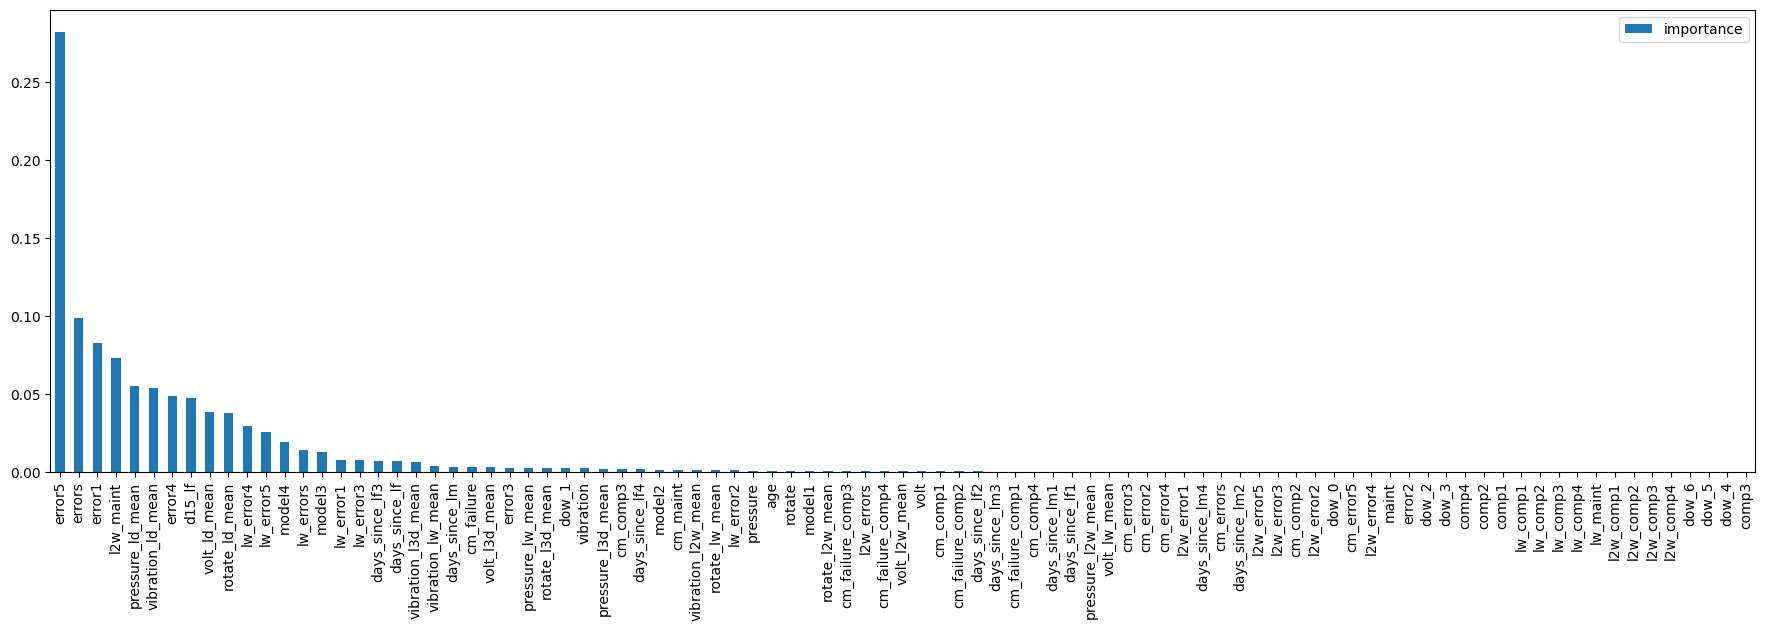

In [274]:
feature_importances.plot(kind='bar', figsize=(22, 6))